In [78]:
from DbManager import DbManager
import pandas as pd
import plotly.express as px
%matplotlib inline

In [3]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

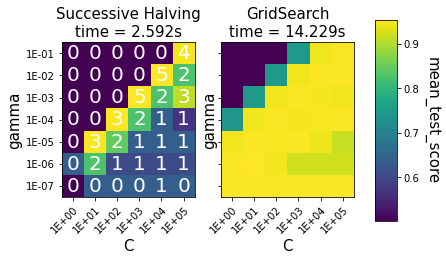

In [4]:
rng = np.random.RandomState(0)
X, y = datasets.make_classification(n_samples=1000, random_state=rng)

gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {'gamma': gammas, 'C': Cs}

clf = SVC(random_state=rng)

tic = time()
gsh = HalvingGridSearchCV(estimator=clf, param_grid=param_grid, factor=2,
                          random_state=rng)
gsh.fit(X, y)
gsh_time = time() - tic

tic = time()
gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(X, y)
gs_time = time() - tic

def make_heatmap(ax, gs, is_sh=False, make_cbar=False):
    """Helper to make a heatmap."""
    results = pd.DataFrame.from_dict(gs.cv_results_)
    results['params_str'] = results.params.apply(str)
    if is_sh:
        # SH dataframe: get mean_test_score values for the highest iter
        scores_matrix = results.sort_values('iter').pivot_table(
                index='param_gamma', columns='param_C',
                values='mean_test_score', aggfunc='last'
        )
    else:
        scores_matrix = results.pivot(index='param_gamma', columns='param_C',
                                      values='mean_test_score')

    im = ax.imshow(scores_matrix)

    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels(['{:.0E}'.format(x) for x in Cs])
    ax.set_xlabel('C', fontsize=15)

    ax.set_yticks(np.arange(len(gammas)))
    ax.set_yticklabels(['{:.0E}'.format(x) for x in gammas])
    ax.set_ylabel('gamma', fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    if is_sh:
        iterations = results.pivot_table(index='param_gamma',
                                         columns='param_C', values='iter',
                                         aggfunc='max').values
        for i in range(len(gammas)):
            for j in range(len(Cs)):
                ax.text(j, i, iterations[i, j],
                        ha="center", va="center", color="w", fontsize=20)

    if make_cbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel('mean_test_score', rotation=-90, va="bottom",
                           fontsize=15)


fig, axes = plt.subplots(ncols=2, sharey=True)
ax1, ax2 = axes

make_heatmap(ax1, gsh, is_sh=True)
make_heatmap(ax2, gs, make_cbar=True)

ax1.set_title('Successive Halving\ntime = {:.3f}s'.format(gsh_time),
              fontsize=15)
ax2.set_title('GridSearch\ntime = {:.3f}s'.format(gs_time), fontsize=15)

plt.show()

In [5]:
db = DbManager("root", "bandtec123", "localhost", "processamento_db")
data_frame = db.read("SELECT * FROM eventos").astype({'categoria':'category'})
data_frame['categoria'] = data_frame['categoria'].cat.codes
data_frame_categoria = data_frame.groupby(['idConsumidor','categoria'])['idEvento'].count().reset_index()
data_frame_categoria.sort_values('idEvento')

Conectado ao banco


,idConsumidor,categoria,idEvento
0,0,0,1
615,696,5,1
616,697,2,1
617,698,0,1
618,698,5,1
...,...,...,...
200,216,4,2
161,176,1,2
121,133,4,2
577,633,4,3


In [31]:
data_frame

,idEvento,idConsumidor,idade,preco,nome,categoria,fkCupom,statusEvento,fkEcommerce,dataCompra,perc
0,1,601,47,1638.43,Oakley,5,2,3,1,18655,0.154
1,2,1076,57,1801.62,Nike,1,3,3,1,18743,0.154
2,3,27,46,2340.63,Adidas,5,1,3,1,18679,0.154
3,4,342,37,1637.50,Versace,4,3,3,1,18687,0.154
4,5,721,46,1555.29,Adidas,5,3,2,1,18667,0.154
...,...,...,...,...,...,...,...,...,...,...,...
995,996,176,21,1860.19,Adidas,4,4,1,1,18667,0.170
996,997,162,45,2141.69,Versace,3,3,2,1,18687,0.170
997,998,775,27,2095.25,Versace,4,2,2,1,18658,0.170
998,999,479,47,1556.98,Adidas,3,4,3,1,18743,0.170


In [55]:
data_frame_group = data_frame.groupby('categoria')['idConsumidor'].count().reset_index().rename(columns={'idConsumidor':'Quantidade'})
data_frame_group['perc'] = data_frame_group.merge(somaTotal, on="categoria")['Quantidade']/data_frame['idConsumidor'].count() *100
data_frame_group

,categoria,Quantidade,perc
0,0,170,17.0
1,1,188,18.8
2,2,174,17.4
3,3,156,15.6
4,4,158,15.8
5,5,154,15.4


In [59]:
data_frame_group = data_frame.groupby('categoria')['preco'].sum().reset_index().rename(columns={'idConsumidor':'Quantidade'})
data_frame_group['perc'] = data_frame_group.merge(somaTotal, on="categoria")['preco']/data_frame['preco'].sum() *100
data_frame_group

,categoria,preco,perc
0,0,337314.43,16.817726
1,1,379724.22,18.932181
2,2,346877.94,17.294540
3,3,314179.23,15.664257
4,4,318145.14,15.861989
5,5,309466.82,15.429307


In [80]:
px.bar(data_frame_group, x='categoria', y='preco')